# Project 3

In this project, you will perform a logistic regression on the admissions data we've been working with in projects 1 and 2.

In [1]:
# Our first step will be to import the packages we need

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import pylab as pl
import numpy as np


/Users/thshih/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
df_raw = pd.read_csv("admissions.csv") #read in data
df = df_raw.dropna() #drop null records
print df.head() #print first few rows

   admit    gre   gpa  prestige
0      0  380.0  3.61       3.0
1      1  660.0  3.67       3.0
2      1  800.0  4.00       1.0
3      1  640.0  3.19       4.0
4      0  520.0  2.93       4.0


In [3]:
# Let's create some summary stat/counts to get an idea of what our data looks like

counts = df.count() #Count the number of records. This will help us see if there are any null records.
shape = df.shape #Show the shape of our data frame.
summary_stats = df.describe() #Show a summary of our data, including counts, means, standard deviations, and quartiles

print "Here are our data counts"
print counts
print "" #I printed blank rows so there was a demarkation between each of the segments
print "Here is the shape of our data"
print shape
print "" #I printed blank rows so there was a demarkation between each of the segments
print "Here are our data set's summary stats"
print summary_stats

Here are our data counts
admit       397
gre         397
gpa         397
prestige    397
dtype: int64

Here is the shape of our data
(397, 4)

Here are our data set's summary stats
            admit         gre         gpa    prestige
count  397.000000  397.000000  397.000000  397.000000
mean     0.317380  587.858942    3.392242    2.488665
std      0.466044  115.717787    0.380208    0.947083
min      0.000000  220.000000    2.260000    1.000000
25%      0.000000  520.000000    3.130000    2.000000
50%      0.000000  580.000000    3.400000    2.000000
75%      1.000000  660.000000    3.670000    3.000000
max      1.000000  800.000000    4.000000    4.000000


# Before we go any further, let's create a data dictionary

Outcome/Covariate | Variable | Description | Type of Variable
--- | ---| ---| ---
outcome | admit | 0 = No, 1 = Yes | categorial/discrete
covariate | gre | GRE score for the applicant | categorial/discrete
covariate | gpa| GPA for the applicant | continuous
covariate | prestige | How prestigious the applicant's undergraduate school is. 1 is the highest and 4 is the lowest | categorical

## Part 1. Frequency Tables

#### 1. Let's create a frequency table of our variables

In [4]:
# frequency table for prestige and whether or not someone was admitted
# The cross tab function will allow us to take our data frame and aggregate / pivot the data based on our variables of interest

print pd.crosstab(df['admit'], df['prestige'], rownames=['admit'])

prestige  1.0  2.0  3.0  4.0
admit                       
0          28   95   93   55
1          33   53   28   12


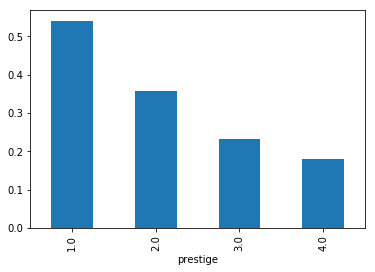

In [5]:
# Let's visualize this data by looking at a bar chart of admissions rates based on undergraduate prestige
# We can clearly see from the output that as a school as a worse prestige level (which in this case is an increased prestige level, admissions rate decreases)

df.groupby('prestige').admit.mean().plot(kind='bar')

## Part 2. Return of dummy variables

#### 2.1 Create class or dummy variables for prestige 

In [6]:
# create a dummy variable for prestige
# to do this, I will use Panda's get_dummies function to create a dummy variable for each of the prestige levels

dummy_ranks = pd.get_dummies(df['prestige'], prefix='prestige')
print dummy_ranks.head()

   prestige_1.0  prestige_2.0  prestige_3.0  prestige_4.0
0             0             0             1             0
1             0             0             1             0
2             1             0             0             0
3             0             0             0             1
4             0             0             0             1


In [7]:
df = df.join(dummy_ranks) #Join in dummy variables, so that it's back into the original data frame

In [8]:
df.head() #print the first few rows of the updated data frame, which added in the prestige dummy variable

,admit,gre,gpa,prestige,prestige_1.0,prestige_2.0,prestige_3.0,prestige_4.0
0,0,380.0,3.61,3.0,0,0,1,0
1,1,660.0,3.67,3.0,0,0,1,0
2,1,800.0,4.00,1.0,1,0,0,0
3,1,640.0,3.19,4.0,0,0,0,1
4,0,520.0,2.93,4.0,0,0,0,1


In [9]:
# Let's do some updated counts to ensure that we did everything correctly
updated_counts = df.count()
updated_shape = df.shape

print "Here are our updated data counts" # We can now see that there's 397 records for our dummy variables
print updated_counts
print "" #I printed blank rows so there was a demarkation between each of the segments
print "Here is the updated shape of our data"
print updated_shape #We can see that we now have 4 additional columns (original shape was 397,4)

Here are our updated data counts
admit           397
gre             397
gpa             397
prestige        397
prestige_1.0    397
prestige_2.0    397
prestige_3.0    397
prestige_4.0    397
dtype: int64

Here is the updated shape of our data
(397, 8)


#### 2.2 When modeling our class variables, how many do we need? 



Answer: In general, we only need n-1 class variables, where n is the number of distinct values in the variable you want to create a dummy variable from. In this case, there are 4 possible "prestige" values, 1 - 4, but we really only need 3, since if you have `prestige 1` , `prestige 2`, and `prestigeg 3`, you can infer which records are `prestige 4` based on the other 3 dummy variables. Therefore, for this exercise, to model our class variables, we only need 3.

## Part 3. Hand calculating odds ratios

Develop your intuition about expected outcomes by hand calculating odds ratios.

In [10]:
# Let's update our data frame to only include the columns we need

cols_to_keep = ['admit', 'gre', 'gpa']
handCalc = df[cols_to_keep].join(dummy_ranks.ix[:, 'prestige_1':])
print handCalc.head()

   admit    gre   gpa  prestige_1.0  prestige_2.0  prestige_3.0  prestige_4.0
0      0  380.0  3.61             0             0             1             0
1      1  660.0  3.67             0             0             1             0
2      1  800.0  4.00             1             0             0             0
3      1  640.0  3.19             0             0             0             1
4      0  520.0  2.93             0             0             0             1


/Users/thshih/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  after removing the cwd from sys.path.


In [11]:
# The below exercises require our crosstab, so here it is again
# crosstab prestige 1 admission 
# frequency table cutting prestige and whether or not someone was admitted
print pd.crosstab(df['admit'], df['prestige'], rownames=['admit'])

prestige  1.0  2.0  3.0  4.0
admit                       
0          28   95   93   55
1          33   53   28   12


#### 3.1 Use the cross tab above to calculate the odds of being admitted to grad school if you attended a #1 ranked college

In [12]:
# The odds of being admitted are (admitted / (admitted + not admitted)). We will want to only look at these values for top prestige schools

odds_top_school = 33.0 / (33+28) #33.0 will turn this into a float so it presents the decimals
print odds_top_school

0.540983606557


#### 3.2 Now calculate the odds of admission if you did not attend a #1 ranked college

In [13]:
# The odds of not being admitted are (admitted / (admitted + not admitted)). We will want to only look at these values now for those that didn't attent a top prestige schools

odds_not_top_school = (53.0 + 28 + 12) / (95 + 93 + 55 + 53 + 28 + 12)
print odds_not_top_school

0.276785714286


#### 3.3 Calculate the odds ratio

In [14]:
# Odds ratio is the odds / (1-odds)

odds_ratio_top_school = 0.540983606557 / (1-0.540983606557)
print odds_ratio_top_school

odds_ratio_not_top_school = 0.276785714286 / (1-0.276785714286)
print odds_ratio_not_top_school

1.17857142857
0.382716049383


In [15]:
# Since the odds ratio for being admitted if you're not from a top school is < 1, let's normalize that

1 / 0.382716049383

2.612903225804513

#### 3.4 Write this finding in a sentenance: 

Answer: 

Your odds of getting into grad school if you attended a top "Prestige 1" undergraduate school is 1.17:1

Your odds of getting into grad school if you didn't attend a top "Prestige 1" undergraduate school is 1:2.61

#### 3.5 Print the cross tab for prestige_4

In [16]:
print pd.crosstab(df['admit'], df['prestige'], rownames=['admit'])

prestige  1.0  2.0  3.0  4.0
admit                       
0          28   95   93   55
1          33   53   28   12


#### 3.6 Calculate the OR 

In [19]:
odds_bottom_school = 12.0/(12+55)
odds_not_bottom_school = (33.0+53+28) / (33+53+28+28+95+93)
odds_ratio_bottom_school = odds_bottom_school / (1-odds_bottom_school)
odds_ratio_not_bottom_school = odds_not_bottom_school / (1-odds_not_bottom_school)


print odds_ratio_bottom_school
print odds_ratio_not_bottom_school

0.218181818182
0.527777777778


In [21]:
# Normalized odds ratio

print 1/0.218181818182
print 1/0.527777777778

4.58333333333
1.8947368421




#### 3.7 Write this finding in a sentence

Answer: 

- The odds of getting into grad school if you went to a "prestige 4" tier school are 0.22:1. Normalized, the odds of getting in are 1:4.58
- The odds of getting into grad school if you didn't go to a "prestige 4" tier school are 0.53:1. Normalized, the odds of getting in are 1:1.89


## Part 4. Analysis

In [22]:
# create a clean data frame for the regression
cols_to_keep = ['admit', 'gre', 'gpa']
data = df[cols_to_keep].join(dummy_ranks.ix[:, 'prestige_2':])
print data.head()

   admit    gre   gpa  prestige_2.0  prestige_3.0  prestige_4.0
0      0  380.0  3.61             0             1             0
1      1  660.0  3.67             0             1             0
2      1  800.0  4.00             0             0             0
3      1  640.0  3.19             0             0             1
4      0  520.0  2.93             0             0             1


We're going to add a constant term for our Logistic Regression. The statsmodels function we're going to be using requires that intercepts/constants are specified explicitly.

In [23]:
# manually add the intercept
data['intercept'] = 1.0

#### 4.1 Set the covariates to a variable called train_cols

In [24]:
# our covariates are everything from GRE onward, so we can use python's 0 index to indicate we want everything from column 1 onward

train_cols = data.columns[1:]

#### 4.2 Fit the model

In [25]:
# this will fit the data based on our training columns & our outcome variable, "admit"
# Stasmodel Logit is a program that will help us create a logistic regression results output

model_fit = sm.Logit(data['admit'], data[train_cols])
model_result = model_fit.fit()

Optimization terminated successfully.
         Current function value: 0.573854
         Iterations 6


#### 4.3 Print the summary results

In [26]:
# This will print a logistic regression summary based on the model_result variable we created above
print model_result.summary()

                           Logit Regression Results                           
Dep. Variable:                  admit   No. Observations:                  397
Model:                          Logit   Df Residuals:                      391
Method:                           MLE   Df Model:                            5
Date:                Wed, 23 Aug 2017   Pseudo R-squ.:                 0.08166
Time:                        17:13:44   Log-Likelihood:                -227.82
converged:                       True   LL-Null:                       -248.08
                                        LLR p-value:                 1.176e-07
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
gre              0.0022      0.001      2.028      0.043    7.44e-05       0.004
gpa              0.7793      0.333      2.344      0.019       0.128       1.431
prestige_2.0    -0.6801      0.317     -2.14

### Here are my initial thoughts on this logistic output

- A single unit increase in GRE & GPA both have a positive impact on grad school admissions. A single unit increase in school prestige (which is actually a "lower" ranked school) has a negative impact on grad school admissions.
- Increases in GPA are more likely to increase grad school admissions vs. increases in GRE. This makes sense intuitively, as the range in GPA scores is much smaller than the range in GRE scores, so each individual unit increase in GPA will matter much more than each individual unit increase in GRE.
- There is a clear negative relationship in terms of school prestige rank & admission rates. As prestige increases (i.e. Prestige becomes "worse"), admissions rates decline. 

#### 4.4 Calculate the odds ratios of the coeffiencents and their 95% CI intervals

hint 1: np.exp(X)

hint 2: conf['OR'] = params
        
           conf.columns = ['2.5%', '97.5%', 'OR']

In [28]:
#Odds ratios

print np.exp(model_result.params) 

gre             1.002221
gpa             2.180027
prestige_2.0    0.506548
prestige_3.0    0.262192
prestige_4.0    0.211525
intercept       0.020716
dtype: float64


In [29]:
#Odds ratios with the 95% confidence interval

params = model_result.params
conf = model_result.conf_int()
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'OR']
print np.exp(conf)

                  2.5%     97.5%        OR
gre           1.000074  1.004372  1.002221
gpa           1.136120  4.183113  2.180027
prestige_2.0  0.272168  0.942767  0.506548
prestige_3.0  0.133377  0.515419  0.262192
prestige_4.0  0.093329  0.479411  0.211525
intercept     0.002207  0.194440  0.020716


#### 4.5 Interpret the OR of Prestige_2

Answer: The odds of getting into graduate school if you went to a "Prestige 2" school decrease by 50.7%, presumably compared to if you went to a top "Prestige 1" school. The 95% confidence interval ranges from 27.2% to 94.3%, which means that with respect to repeated sampling, our true mean (in this case, likelihood of graduate school acceptance) will be between these values 95% of the time. 

Interestingly enough - there is the biggest drop in odds from Prestige 2 schools, at ~50.7%. Prestige 3 sees another ~26.2% decrease, while prestige 4 sees another ~21.2% decrease in admissions rates odds. So, while the biggest comparitive drop comes from being at a Prestige 2 vs. 1 school, each successive "drop" (or increase) in school rank will significantly decrease your admissions likelihood.

#### 4.6 Interpret the OR of GPA

Answer: For every 1 unit increase in GPA, your odds of being accepted into graduate school increase by 2.18%. The 95% confidence interval ranges from 1.14% to 4.18%, which means that with respect to repeated sampling, our true mean (in this case, likelihood of graduate school acceptance) will be between these values 95% of the time.

## Part 5: Predicted probablities


As a way of evaluating our classifier, we're going to recreate the dataset with every logical combination of input values. This will allow us to see how the predicted probability of admission increases/decreases across different variables. First we're going to generate the combinations using a helper function called cartesian (above).

We're going to use np.linspace to create a range of values for "gre" and "gpa". This creates a range of linearly spaced values from a specified min and maximum value--in our case just the min/max observed values.

In [76]:
def cartesian(arrays, out=None):
    """
    Generate a cartesian product of input arrays.
    Parameters
    ----------
    arrays : list of array-like
        1-D arrays to form the cartesian product of.
    out : ndarray
        Array to place the cartesian product in.
    Returns
    -------
    out : ndarray
        2-D array of shape (M, len(arrays)) containing cartesian products
        formed of input arrays.
    Examples
    --------
    >>> cartesian(([1, 2, 3], [4, 5], [6, 7]))
    array([[1, 4, 6],
           [1, 4, 7],
           [1, 5, 6],
           [1, 5, 7],
           [2, 4, 6],
           [2, 4, 7],
           [2, 5, 6],
           [2, 5, 7],
           [3, 4, 6],
           [3, 4, 7],
           [3, 5, 6],
           [3, 5, 7]])
    """

    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    m = n / arrays[0].size
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m,1:])
        for j in xrange(1, arrays[0].size):
            out[j*m:(j+1)*m,1:] = out[0:m,1:]
    return out

In [77]:
# instead of generating all possible values of GRE and GPA, we're going
# to use an evenly spaced range of 10 values from the min to the max 
gres = np.linspace(data['gre'].min(), data['gre'].max(), 10)
print gres
# array([ 220.        ,  284.44444444,  348.88888889,  413.33333333,
#         477.77777778,  542.22222222,  606.66666667,  671.11111111,
#         735.55555556,  800.        ])
gpas = np.linspace(data['gpa'].min(), data['gpa'].max(), 10)
print gpas
# array([ 2.26      ,  2.45333333,  2.64666667,  2.84      ,  3.03333333,
#         3.22666667,  3.42      ,  3.61333333,  3.80666667,  4.        ])


# enumerate all possibilities
combos = pd.DataFrame(cartesian([gres, gpas, [1, 2, 3, 4], [1.]]))

[ 220.          284.44444444  348.88888889  413.33333333  477.77777778
  542.22222222  606.66666667  671.11111111  735.55555556  800.        ]
[ 2.26        2.45333333  2.64666667  2.84        3.03333333  3.22666667
  3.42        3.61333333  3.80666667  4.        ]


In [78]:
combos.head() #Hey Wait a second! Where did our column titles go? See below!

,0,1,2,3
0,220.0,2.260000,1.0,1.0
1,220.0,2.260000,2.0,1.0
2,220.0,2.260000,3.0,1.0
3,220.0,2.260000,4.0,1.0
4,220.0,2.453333,1.0,1.0


#### 5.1 Recreate the dummy variables

In [79]:
# recreate the dummy variables

combos.columns = ['gre', 'gpa', 'prestige', 'intercept'] # We need to re-update our column header names
dummy_variable = pd.get_dummies(combos['prestige'], prefix = 'prestige') #this will recreate our dummy variables
dummy_variable.columns = ['prestige_1.0', 'prestige_2.0', 'prestige_3.0', 'prestige_4.0'] #this will indicate our dummy variable column names

# keep only what we need for making predictions

columns_to_keep = ['gre', 'gpa', 'prestige', 'intercept'] #here are the columns we will want to keep
combos = combos[columns_to_keep].join(dummy_variable.ix[:, 'prestige_2':]) #this joins the dummy variable back into our updated data set

/Users/thshih/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  # Remove the CWD from sys.path while we load stuff.


In [80]:
# Awesome! What does our new data set look like?

combos.head()

,gre,gpa,prestige,intercept,prestige_2.0,prestige_3.0,prestige_4.0
0,220.0,2.260000,1.0,1.0,0,0,0
1,220.0,2.260000,2.0,1.0,1,0,0
2,220.0,2.260000,3.0,1.0,0,1,0
3,220.0,2.260000,4.0,1.0,0,0,1
4,220.0,2.453333,1.0,1.0,0,0,0


In [81]:
# Let's do some basic descriptive stats on our new data set

counts = combos.count() #Count the number of records
shape = combos.shape #Show the shape of our combos data frame
summary_stats = combos.describe() #Show a summary of our data, including counts, means, standard deviations, and quartiles

print "Here are our data counts"
print counts
print "" #I printed blank rows so there was a demarkation between each of the segments
print "Here is the shape of our data"
print shape
print "" #I printed blank rows so there was a demarkation between each of the segments
print "Here are our data set's summary stats"
print summary_stats

Here are our data counts
gre             400
gpa             400
prestige        400
intercept       400
prestige_2.0    400
prestige_3.0    400
prestige_4.0    400
dtype: int64

Here is the shape of our data
(400, 7)

Here are our data set's summary stats
              gre         gpa    prestige  intercept  prestige_2.0  \
count  400.000000  400.000000  400.000000      400.0    400.000000   
mean   510.000000    3.130000    2.500000        1.0      0.250000   
std    185.334387    0.556003    1.119434        0.0      0.433555   
min    220.000000    2.260000    1.000000        1.0      0.000000   
25%    348.888889    2.646667    1.750000        1.0      0.000000   
50%    510.000000    3.130000    2.500000        1.0      0.000000   
75%    671.111111    3.613333    3.250000        1.0      0.250000   
max    800.000000    4.000000    4.000000        1.0      1.000000   

       prestige_3.0  prestige_4.0  
count    400.000000    400.000000  
mean       0.250000      0.250000  
std 

In [82]:
train_cols

Index([u'gre', u'gpa', u'prestige_2.0', u'prestige_3.0', u'prestige_4.0',
       u'intercept'],
      dtype='object')

#### 5.2 Make predictions on the enumerated dataset

In [83]:
# we will use the model results from above to do this

combos['admit_pred'] = model_result.predict(combos[train_cols])

In [85]:
combos.head() #Our new combos data frame shows the admissions predictions for each of the applicants

,gre,gpa,prestige,intercept,prestige_2.0,prestige_3.0,prestige_4.0,admit_pred
0,220.0,2.260000,1.0,1.0,0,0,0,0.164173
1,220.0,2.260000,2.0,1.0,1,0,0,0.090492
2,220.0,2.260000,3.0,1.0,0,1,0,0.048977
3,220.0,2.260000,4.0,1.0,0,0,1,0.039890
4,220.0,2.453333,1.0,1.0,0,0,0,0.185907


#### 5.3 Interpret findings for the last 4 observations

Answer: 

## Bonus

Plot the probability of being admitted into graduate school, stratified by GPA and GRE score.

In [87]:
df.head()

,admit,gre,gpa,prestige,prestige_1.0,prestige_2.0,prestige_3.0,prestige_4.0
0,0,380.0,3.61,3.0,0,0,1,0
1,1,660.0,3.67,3.0,0,0,1,0
2,1,800.0,4.00,1.0,1,0,0,0
3,1,640.0,3.19,4.0,0,0,0,1
4,0,520.0,2.93,4.0,0,0,0,1


In [97]:
# To do this, we're going to have to create bins. Let's first create bins by GPA. After some research from good 'ole Google, I am going to use the "cut" function
# For simplicity, I'm going to use our original data frame, df
# Here's the resource I used: https://chrisalbon.com/python/pandas_binning_data.html
# Let's create bins based on quartiles

df.describe()

,admit,gre,gpa,prestige,prestige_1.0,prestige_2.0,prestige_3.0,prestige_4.0
count,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000
mean,0.317380,587.858942,3.392242,2.488665,0.153652,0.372796,0.304786,0.168766
std,0.466044,115.717787,0.380208,0.947083,0.361070,0.484159,0.460898,0.375017
min,0.000000,220.000000,2.260000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,520.000000,3.130000,2.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,580.000000,3.400000,2.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,660.000000,3.670000,3.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,800.000000,4.000000,4.000000,1.000000,1.000000,1.000000,1.000000


In [102]:
# Now we can makes some GPA bins

gpa_bins = [2.26,3.13,3.4,3.67,4.0] #Define the bin ranges
gpa_bins_names = ['1: Bottom 25%', '2: 25-50th percentile', '3: 50-75th percentile', '4: Top 25%'] #name the bins
categories = pd.cut(df['gpa'], gpa_bins, labels=gpa_bins_names) #create a variable called categories which creates bins
df['gpa_bins'] = categories #add new column called GPA bins, make it our "categories" variable
df.head() #awesome! We now have GPA bins

,admit,gre,gpa,prestige,prestige_1.0,prestige_2.0,prestige_3.0,prestige_4.0,categories,gpa_bins,gre_bins
0,0,380.0,3.61,3.0,0,0,1,0,Between 3.0 & 4.0,3: 50-75th percentile,Bottom 25%
1,1,660.0,3.67,3.0,0,0,1,0,Between 3.0 & 4.0,3: 50-75th percentile,50-75th percentile
2,1,800.0,4.00,1.0,1,0,0,0,Between 3.0 & 4.0,4: Top 25%,Top 25%
3,1,640.0,3.19,4.0,0,0,0,1,Between 3.0 & 4.0,2: 25-50th percentile,50-75th percentile
4,0,520.0,2.93,4.0,0,0,0,1,Between 2.0 & 3.0,1: Bottom 25%,Bottom 25%


In [103]:
# Let's now do the same thing for GRE bins. Because I've never taken the GRE before, and I have no idea of what a "good" score is,
# let's look again at our data set and make the bins based on quartiles

df.describe()

,admit,gre,gpa,prestige,prestige_1.0,prestige_2.0,prestige_3.0,prestige_4.0
count,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000
mean,0.317380,587.858942,3.392242,2.488665,0.153652,0.372796,0.304786,0.168766
std,0.466044,115.717787,0.380208,0.947083,0.361070,0.484159,0.460898,0.375017
min,0.000000,220.000000,2.260000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,520.000000,3.130000,2.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,580.000000,3.400000,2.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,660.000000,3.670000,3.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,800.000000,4.000000,4.000000,1.000000,1.000000,1.000000,1.000000


In [104]:
# Cool - now we can make our GRE bins 

gre_bins = [220,520,580,660,800] #Define the bin ranges
gre_bins_names = ['1: Bottom 25%', '2: 25-50th percentile', '3: 50-75th percentile', '4: Top 25%'] #name the bins
categories_gre = pd.cut(df['gre'], gre_bins, labels=gre_bins_names) #create a variable called categories which creates bins
df['gre_bins'] = categories_gre #add new column called GRE bins, make it our "categories" variable
df.head() #awesome! We now have GRE bins

,admit,gre,gpa,prestige,prestige_1.0,prestige_2.0,prestige_3.0,prestige_4.0,categories,gpa_bins,gre_bins
0,0,380.0,3.61,3.0,0,0,1,0,Between 3.0 & 4.0,3: 50-75th percentile,1: Bottom 25%
1,1,660.0,3.67,3.0,0,0,1,0,Between 3.0 & 4.0,3: 50-75th percentile,3: 50-75th percentile
2,1,800.0,4.00,1.0,1,0,0,0,Between 3.0 & 4.0,4: Top 25%,4: Top 25%
3,1,640.0,3.19,4.0,0,0,0,1,Between 3.0 & 4.0,2: 25-50th percentile,3: 50-75th percentile
4,0,520.0,2.93,4.0,0,0,0,1,Between 2.0 & 3.0,1: Bottom 25%,1: Bottom 25%


In [105]:
# Now that we have bins, let's create some odds ratios. Let's start w/ GPA bins

print pd.crosstab(df['admit'], df['gpa_bins'], rownames=['admit'])

gpa_bins  1: Bottom 25%  2: 25-50th percentile  3: 50-75th percentile  \
admit                                                                   
0                    79                     80                     55   
1                    22                     23                     40   

gpa_bins  4: Top 25%  
admit                 
0                 56  
1                 41  


In [106]:
# Let's calculate the odds ratio based on if you were in the top 25% in terms of GPA
# Reminder that the odds = admitted / (admitted + not admitted)
# Odss ratio = odds / (1-odds)

odds_top_25_pct = 41.0 / (41 + 56)
odds_not_top_25_pct = (22.0 + 23 + 40) / (22 + 23 + 40 + 79 + 80 + 55)
odds_ratio_top_25 = odds_top_25_pct / (1-odds_top_25_pct)
odds_ratio_not_top_25_pct = odds_not_top_25_pct / (1-odds_not_top_25_pct)

print odds_ratio_top_25
print odds_ratio_not_top_25_pct

0.732142857143
0.397196261682


In [108]:
# Interpreting the odds - Let's normalize those numbers

print 1/0.732142857143
print 1/0.397196261682

1.36585365854
2.51764705883


### GPA odds summary 

- The odds of getting into grad school if you are in the top 25% for GPA are 0.73:1. Normalized, your odds are 1:1.37.
- The odds of getting into grad school if you aren't in the top 25% for GPA are 0.397:1. Normalized, your odds are 1:2.52.

In [109]:
# Let's repeat this fun stuff with GRE bins!

print pd.crosstab(df['admit'], df['gre_bins'], rownames=['admit'])

gre_bins  1: Bottom 25%  2: 25-50th percentile  3: 50-75th percentile  \
admit                                                                   
0                    93                     58                     60   
1                    28                     21                     37   

gre_bins  4: Top 25%  
admit                 
0                 59  
1                 40  


In [110]:
# Let's calculate the odds ratio based on if you were in the top 25% in terms of GRE
# Reminder that the odds = admitted / (admitted + not admitted)
# Odss ratio = odds / (1-odds)

odds_top_25_pct = 40.0 / (40 + 59)
odds_not_top_25_pct = (28.0 + 21 + 37) / (28 + 21 + 37 + 93 + 58 + 60)
odds_ratio_top_25 = odds_top_25_pct / (1-odds_top_25_pct)
odds_ratio_not_top_25_pct = odds_not_top_25_pct / (1-odds_not_top_25_pct)

print odds_ratio_top_25
print odds_ratio_not_top_25_pct

0.677966101695
0.407582938389


In [111]:
# Interpreting the odds - Let's normalize those numbers

print 1/0.677966101695
print 1/0.407582938389

1.475
2.45348837209


### GRE odds summary 

- The odds of getting into grad school if you are in the top 25% for GRE are 0.68:1. Normalized, your odds are 1:1.48.
- The odds of getting into grad school if you aren't in the top 25% for GRE are 0.41:1. Normalized, your odds are 1:2.45.